<a href="https://colab.research.google.com/github/the-faisalahmed/Optimization/blob/main/Numbrix_and_Hidato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

!pip install pyomo
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.opt import SolverStatus
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

# **Numbrix Optimization Problem**

**Numbrix** is a logic puzzle slightly similar to Sudoku. It depicts a n$\times$n board with some numbers already in place ranging from 1 to N (where N = n^2).

The goal of the game is as follows:
- On the empty spaces of the grid, place a number from 1 to N. Each number must be used exactly once.
- Each number must be connected to the next consecutive number either horizontally or vertically, but never diagonally (**Hidato** allows diagonal moves). There are no skipped numbers between consecutive ones.
- If you can draw a path from 1 to N, you win!

### Optimization

This process can be optimized using constraint programming. If we model a certain Numbrix board with some numbers already given to us, we can specify the variables (numbers to place in each grid) and constraints (goals mentioned above) and find an optimal solution. We use constraint progamming in this scenario as there is no objective function to minimize or maximize.

Consider the following 9$\times$9 numbrix board provided by https://parade.com/numbrix/.

In [176]:
#Size of cols, rows
n = 9
N = n*n

In [177]:
#Inputing preset numbers

row1 = [1,41,47,53]
row2 = [7,45,51]
row3 = [9,63]
row4 = [15,81]
row5 = [21,61]
row6 = [19,35,79]
row7 = [25,31,69,73]

v = {}

counter = 0
for i in [2,4,6,8]:
  v[i,2] = row1[counter]
  v[i,8] = row7[counter]
  counter += 1

counter = 0
for i in [3,5,7]:
  v[i,3] = row2[counter]
  v[i,7] = row6[counter]
  counter += 1

counter = 0
for i in [2,8]:
  v[i,4] = row3[counter]
  v[i,6] = row5[counter]
  counter += 1

counter = 0
for i in [3,7]:
  v[i,5] = row4[counter]
  counter += 1

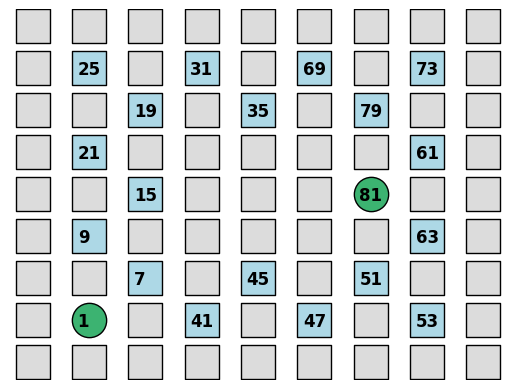

In [180]:
x = {}
for i,j in list(itertools.product(range(1,n+1),range(1,n+1))):
  x[i,j] = 0

for i,j in v:
  x[i,j] = v[i,j]

for i,j in x:
  if x[i,j] == 0:
    plt.scatter(i,j,marker = 's',s=610, linewidth=1,edgecolor='black', c=['#DCDCDC'])
  elif x[i,j] in [1,N]:
    plt.scatter(i,j,marker = 'o',s=610, linewidth=1,edgecolor='black', c=['#3CB371'])
    plt.text(i-0.2,j-0.15,x[i,j],fontweight='bold',fontsize='12')
  else:
    plt.scatter(i,j,marker = 's',s=610, linewidth=1,edgecolor='black', c=['#ADD8E6'])
    plt.text(i-0.2,j-0.15,x[i,j],fontweight='bold',fontsize='12')

plt.axis('off')
plt.show()

# **Formulating Optimization Problem**

### **Sets**
- $ i \in I = \{1,2,3,\ldots n\} \quad$ Set of rows beginning from the bottom of the board.
- $ j \in J = \{1,2,3,\ldots n\} \quad$ Set of columns beginning from the left of the board.
- $ k \in K = \{1,2,3,\ldots n^2\} \quad$ Set of all numbers allowed in grid.

### **Variables**
- $ X_{i,j,k} \in \{0,1\} \quad$ Binary decision variable.
----
----
\begin{align}
    & \min
    & & 1 &  \\
    & \text{s.t.}
    & & \sum_{ i \in I  } \sum_{ j \in J  } X_{i,j,k} = 1 &  \qquad \forall k \in K  \tag{1} \\
    &&& \sum_{ k \in K  } X_{i,j,k} = 1 &  \qquad \forall i,j \in I \times J  \tag{2} \\
      &&& f(x) = \begin{cases}
          X_{i,j,k} - X_{i+1,j,k+1} - X_{i,j+1,k+1} \leq 0, && (i,j) = (1,1) \\
          X_{i,j,k} - X_{i-1,j,k+1} - X_{i,j+1,k+1} \leq 0, && (i,j) = (n,1) \\
          X_{i,j,k} - X_{i,j-1,k+1} - X_{i+1,j,k+1} \leq 0, && (i,j) = (1,n) \\
          X_{i,j,k} - X_{i,j-1,k+1} - X_{i-1,j,k+1} \leq 0, && (i,j) = (n,n) \\
      \end{cases}
    &  \qquad \forall (i,j) \in [(1,1),(n,1),(1,n),(n,n)] \tag{3}
    \\
      &&& g(x) = \begin{cases}
      X_{i,j,k} - X_{i-1,j,k+1} - X_{i+1,j,k+1} - X_{i,j+1,k+1} \leq 0, && (1 < i < n) ∧ j = 1\\
      X_{i,j,k} - X_{i-1,j,k+1} - X_{i+1,j,k+1} - X_{i,j-1,k+1} \leq 0, && (1 < i < n) ∧ j = n \\
      X_{i,j,k} - X_{i,j-1,k+1} - X_{i,j+1,k+1} - X_{i+1,j,k+1} \leq 0, && (1 < j < n) ∧ i = 1\\
      X_{i,j,k} - X_{i,j-1,k+1} - X_{i,j+1,k+1} - X_{i-1,j,k+1} \leq 0, && (1 < j < n) ∧ i = n \\
      \end{cases}
    &  \qquad \forall i,j \in I \times J \tag{4} \\
      &&& h(x) = \begin{cases}
      X_{i,j,k} - X_{i-1,j,k+1} - X_{i+1,j,k+1} - X_{i,j-1,k+1} - X_{i,j+1,k+1} \leq 0, && (1 < i < n) ∧ (1 < j < n)\\
      \end{cases}
    &  \qquad \forall i,j \in I \times J \tag{5} \\
    & \text{w.b.}
    & & X & \qquad \in \left\{ 0 , 1 \right \}  \tag{6}
\end{align}

Because this problem does not need an objective function, we fix the objective function to '1'.

Below are the explanations of each constraint:
- (1) specifies that all values from 1 through N should be used exactly once on the board.
- (2) specifies that for each space on the board, there should only be one number selected.
- (3) considers the corner spaces on the board and looks at the spots adjacent to them both horizontally and vertically. It states that at most 1 of those adjacent spots should contain the next number greater than the number in the corner.
- (4) uses the same technique as (3) but considers the bottom row (first 2 equations) and top row (second two equations) excluding the corners.
- (5) uses the same technique as (3) but considers the interior points, excluding all edge points.
- (6) states that X is a binary variable.

In [181]:
model = ConcreteModel()
model.I = RangeSet(1,n)
model.J = RangeSet(1,n)
model.K = RangeSet(1,N)
model.X = Var(model.I, model.J, model.K, domain = Binary)

#Fixing given values in Numbrix grid
for i,j in v:
  model.X[(i,j,v[i,j])].fix(1)

#All values should be used once
def c_rule1(model,k):
  return sum(model.X[(i,j,k)] for i in model.I for j in model.J) == 1
model.c1 = Constraint(model.K, rule = c_rule1)

#All squares have only one value
def c_rule2(model,i,j):
  return sum(model.X[(i,j,k)] for k in model.K) == 1
model.c2 = Constraint(model.I,model.J, rule = c_rule2)

# Corners must be sequential
def snake(model,i,j,k):
    #Corners
    if (i,j) == (1,1):
      return model.X[(i,j),k] - model.X[(i,j+1),k+1] - model.X[(i+1,j),k+1] <= 0
    elif (i,j) == (n,1):
      return model.X[(i,j),k] - model.X[(i-1,j),k+1] - model.X[(i,j+1),k+1] <= 0
    elif (i,j) == (1,n):
      return model.X[(i,j),k] - model.X[(i,j-1),k+1] - model.X[(i+1,j),k+1] <= 0
    elif (i,j) == (n,n):
      return model.X[(i,j),k] - model.X[(i,j-1),k+1] - model.X[(i-1,j),k+1] <= 0
    #Bottom row
    elif 1 < i < n and j == 1:
      return model.X[(i,j),k] - model.X[(i-1,j),k+1] - model.X[(i+1,j),k+1] - model.X[(i,j+1),k+1] <= 0
    #Top row
    elif 1 < i < n and j == n:
      return model.X[(i,j),k] - model.X[(i-1,j),k+1] - model.X[(i+1,j),k+1] - model.X[(i,j-1),k+1] <= 0
    #Left edge
    elif 1 < j < n and i == 1:
      return model.X[(i,j),k] - model.X[(i,j-1),k+1] - model.X[(i,j+1),k+1] - model.X[(i+1,j),k+1] <= 0
    #Right edge
    elif 1 < j < n and i == n:
      return model.X[(i,j),k] - model.X[(i,j-1),k+1] - model.X[(i,j+1),k+1] - model.X[(i-1,j),k+1] <= 0
    #Interior
    elif 1 < i < n and 1 < j < n:
      return model.X[(i,j),k] - model.X[(i+1,j),k+1] - model.X[(i-1,j),k+1] - model.X[(i,j+1),k+1] - model.X[(i,j-1),k+1] <= 0
    else: return Constraint.Skip()
model.snake = Constraint(list(itertools.product(range(1,n+1),range(1,n+1))),range(1,N),rule = snake)

model.obj = Objective(expr=1)

In [ ]:
from pyomo.contrib.latex_printer import latex_printer

#Optimization problem in latex form

#latex_printer(model)

In [182]:
# Solve model
opt = SolverFactory('cbc')
result = opt.solve(model)

if (result.solver.status == SolverStatus.ok) and \
    (result.solver.termination_condition == TerminationCondition.optimal):
    # Do something when the solution in optimal and feasible
    print('Solution is Optimal')
elif (result.solver.termination_condition == TerminationCondition.infeasible):
    # Do something when model in infeasible
    print('Solution is Infeasible')
else:
        # Something else is wrong
    print("Solver Status:",  result.solver.status)

# Solve time
print('Solve Time: ', result.solver.wallclock_time)

Solution is Optimal
Solve Time:  0.19


In [183]:
#Reshaping
x_vals = pd.Series(model.X.extract_values(), name='vals')
g = x_vals[x_vals>0]
p = g.reset_index()
b = np.reshape(p['level_2'],(n,n), order = 'F')
np.flip(b,0)
h = {}
for i in range(1,N+1):
  h[np.where(b==i)[1][0]+1,np.where(b==i)[0][0]+1] = i
t = np.reshape(list(h.keys()),(N,2)).T

## Run the code below to see the path from 1 to n$^2$

<ipython-input-184-966794f23666>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(t[0][:i],t[1][:i],'-bo',c='r', lw=2);


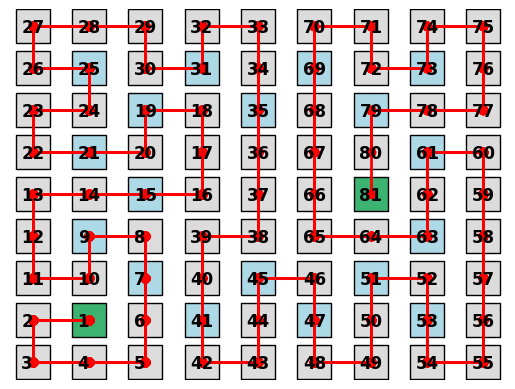

  adding: content/numbrix_folder/ (stored 0%)
  adding: content/numbrix_folder/numbrix_image23_pic.jpg (deflated 33%)
  adding: content/numbrix_folder/numbrix_image17_pic.jpg (deflated 35%)
  adding: content/numbrix_folder/numbrix_image29_pic.jpg (deflated 32%)
  adding: content/numbrix_folder/numbrix_image72_pic.jpg (deflated 22%)
  adding: content/numbrix_folder/numbrix_image75_pic.jpg (deflated 21%)
  adding: content/numbrix_folder/numbrix_image56_pic.jpg (deflated 24%)
  adding: content/numbrix_folder/numbrix_image8_pic.jpg (deflated 39%)
  adding: content/numbrix_folder/numbrix_image4_pic.jpg (deflated 41%)
  adding: content/numbrix_folder/numbrix_image24_pic.jpg (deflated 33%)
  adding: content/numbrix_folder/numbrix_image50_pic.jpg (deflated 25%)
  adding: content/numbrix_folder/numbrix_image68_pic.jpg (deflated 22%)
  adding: content/numbrix_folder/numbrix_image14_pic.jpg (deflated 37%)
  adding: content/numbrix_folder/numbrix_image20_pic.jpg (deflated 34%)
  adding: content/nu

In [184]:
from IPython import display
from time import sleep
!mkdir numbrix_folder

#Plotting snake
plt.axis('off')
for i,j in x:
  if x[i,j] == 0:
    plt.scatter(i,j,marker = 's',s=610, linewidth=1,edgecolor='black', c=['#DCDCDC'])
  elif x[i,j] in [1,N]:
    plt.scatter(i,j,marker = 's',s=610, linewidth=1,edgecolor='black', c=['#3CB371'])
    plt.text(i-0.2,j-0.15,x[i,j],fontweight='bold',fontsize='12')
  else:
    plt.scatter(i,j,marker = 's',s=610, linewidth=1,edgecolor='black', c=['#ADD8E6'])
    plt.text(i-0.2,j-0.15,x[i,j],fontweight='bold',fontsize='12')

for i in range(1,len(t[0])+1):
  plt.plot(t[0][:i],t[1][:i],'-bo',c='r', lw=2);
  if x[(list(h.keys())[i-1][0],list(h.keys())[i-1][1])] == 0:
    plt.text(list(h.keys())[i-1][0]-0.2,list(h.keys())[i-1][1]-0.15,i,fontweight='bold',fontsize='12')
  else: continue
  display.display(plt.gcf())
  plt.savefig('/content/numbrix_folder/numbrix_image%d_%s'%(i,'pic.jpg'))
  display.clear_output(wait=True)
  sleep(0.02)
plt.show();

!zip -r /content/numbrix_images.zip /content/numbrix_folder

# **Hidato**

**Hidato** follows the exact same rules as Numbrix, only diagonal moves *are* allowed and there are often blocks that can not be used.

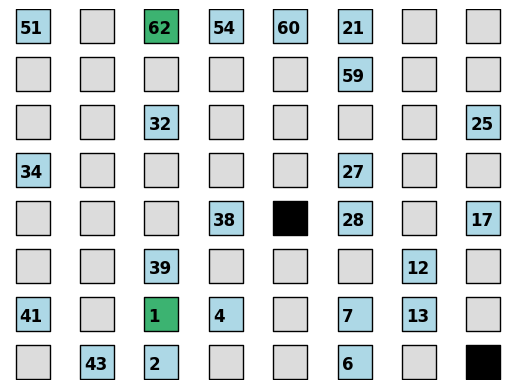

In [170]:
import itertools
import matplotlib.pyplot as plt

v = {(2,1): 43, (3,1): 2, (6,1): 6,
    (1,2): 41, (3,2): 1, (4,2): 4, (6,2): 7, (7,2): 13,
     (3,3): 39, (7,3): 12,
     (4,4): 38, (6,4): 28, (8,4): 17,
     (1,5): 34, (6,5): 27,
     (3,6): 32, (8,6): 25,
     (6,7): 59,
     (1,8): 51, (3,8): 62, (4,8): 54, (5,8): 60, (6,8): 21}
blocked = {1: (8,1), 2: (5,4)}

n = 8
N = n*n - len(blocked)

x = {}
for i,j in list(itertools.product(range(1,n+1),range(1,n+1))):
  x[i,j] = 0

for i,j in v:
  x[i,j] = v[i,j]

for i,j in x:
  if (i,j) in blocked.values():
    plt.scatter(i,j,marker = 's',s=610, linewidth=1,edgecolor='black', c=['#000000'])
  elif x[i,j] == 0:
    plt.scatter(i,j,marker = 's',s=610, linewidth=1,edgecolor='black', c=['#DCDCDC'])
  elif x[i,j] in [1,N]:
    plt.scatter(i,j,marker = 's',s=610, linewidth=1,edgecolor='black', c=['#3CB371'])
    plt.text(i-0.2,j-0.15,x[i,j],fontweight='bold',fontsize='12')
  else:
    plt.scatter(i,j,marker = 's',s=610, linewidth=1,edgecolor='black', c=['#ADD8E6'])
    plt.text(i-0.2,j-0.15,x[i,j],fontweight='bold',fontsize='12')

plt.axis('off')
plt.show()

# **Solving Hidato**

In [75]:
model = ConcreteModel()
model.I = RangeSet(1,n)
model.J = RangeSet(1,n)
model.K = RangeSet(1,n*n)
model.X = Var(model.I, model.J, model.K, domain = Binary)

#Fixing given values in Numbrix grid and empty grid
for i,j in v:
    model.X[(i,j,v[i,j])].fix(1)
for i,j in blocked.values():
  for k in model.K:
    model.X[(i,j,k)].fix(0)

#All valid values should be used once
def c_rule1(model,k):
  return sum(model.X[(i,j,k)] for i in model.I for j in model.J) == 1
model.c1 = Constraint(RangeSet(1,N), rule = c_rule1)

#All squares have only one valid value
def c_rule2(model,i,j):
  if (i,j) not in blocked.values():
    return sum(model.X[(i,j,k)] for k in model.K) == 1
  else:
    return Constraint.Skip
model.c2 = Constraint(model.I,model.J, rule = c_rule2)

# Corners must be sequential
def snake(model,i,j,k):
  if (i,j) not in blocked.values():
    #Corners
    if (i,j) == (1,1):
      return model.X[(i,j),k] - model.X[(i,j+1),k+1] - model.X[(i+1,j),k+1] - model.X[(i+1,j+1),k+1] <= 0
    elif (i,j) == (n,1):
      return model.X[(i,j),k] - model.X[(i-1,j),k+1] - model.X[(i,j+1),k+1] - model.X[(i-1,j+1),k+1] <= 0
    elif (i,j) == (1,n):
      return model.X[(i,j),k] - model.X[(i,j-1),k+1] - model.X[(i+1,j),k+1] - model.X[(i+1,j-1),k+1] <= 0
    elif (i,j) == (n,n):
      return model.X[(i,j),k] - model.X[(i,j-1),k+1] - model.X[(i-1,j),k+1] - model.X[(i-1,j-1),k+1] <= 0
    #Bottom row
    elif 1 < i < n and j == 1:
      return model.X[(i,j),k] - model.X[(i-1,j),k+1] - model.X[(i-1,j+1),k+1] - model.X[(i,j+1),k+1] \
      - model.X[(i+1,j+1),k+1] - model.X[(i+1,j),k+1] <= 0
    #Top row
    elif 1 < i < n and j == n:
      return model.X[(i,j),k] - model.X[(i-1,j),k+1] - model.X[(i-1,j-1),k+1] - model.X[(i,j-1),k+1] \
      - model.X[(i+1,j-1),k+1] - model.X[(i+1,j),k+1] <= 0
    #Left edge
    elif 1 < j < n and i == 1:
      return model.X[(i,j),k] - model.X[(i,j-1),k+1] - model.X[(i+1,j-1),k+1] - model.X[(i+1,j),k+1] \
      - model.X[(i+1,j+1),k+1] - model.X[(i,j+1),k+1]<= 0
    #Right edge
    elif 1 < j < n and i == n:
      return model.X[(i,j),k] - model.X[(i,j-1),k+1] - model.X[(i-1,j-1),k+1] - model.X[(i-1,j),k+1] \
      - model.X[(i-1,j+1),k+1] -  model.X[(i,j+1),k+1]<= 0
    #Interior
    elif 1 < i < n and 1 < j < n:
      return model.X[(i,j),k] - model.X[(i,j-1),k+1] - model.X[(i-1,j-1),k+1] - model.X[(i-1,j),k+1] - model.X[(i-1,j+1),k+1] \
      - model.X[(i,j+1),k+1] - model.X[(i+1,j+1),k+1] - model.X[(i+1,j),k+1] - model.X[(i+1,j-1),k+1]<= 0
    else: return Constraint.Skip
  else: return model.X[i,j,k] == 0
model.snake = Constraint(list(itertools.product(range(1,n+1),range(1,n+1))),range(1,N),rule = snake)

model.obj = Objective(expr=1)

In [76]:
# Solve model
opt = SolverFactory('cbc')
result = opt.solve(model)

if (result.solver.status == SolverStatus.ok) and \
    (result.solver.termination_condition == TerminationCondition.optimal):
    # Do something when the solution in optimal and feasible
    print('Solution is Optimal')
elif (result.solver.termination_condition == TerminationCondition.infeasible):
    # Do something when model in infeasible
    print('Solution is Infeasible')
else:
        # Something else is wrong
    print("Solver Status:",  result.solver.status)

# Solve time
print('Solve Time: ', result.solver.wallclock_time)

Solution is Optimal
Solve Time:  0.23


In [152]:
#Reshaping
x_vals = pd.Series(model.X.extract_values(), name='vals')
count = 0
for i,j in blocked.values():
  x_vals[i,j,n*n - count] = 1
  count+=1
g = x_vals[x_vals>0]
p = g.reset_index()
b = np.reshape(p['level_2'],(n,n), order = 'F')
np.flip(b,0)
h = {}
for i in range(1,n*n+1):
  h[np.where(b==i)[1][0]+1,np.where(b==i)[0][0]+1] = i
t = np.reshape(list(h.keys()),(n*n,2)).T

<ipython-input-171-5eb6b3a77b8c>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(t[0][:i],t[1][:i],'-bo',c='r', lw=2);


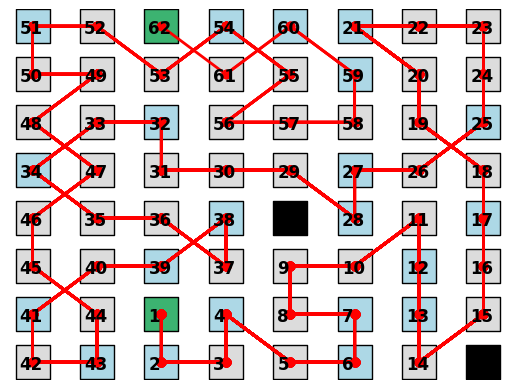

In [171]:
from IPython import display
from time import sleep
!mkdir new_folder

#Plotting snake
plt.axis('off')
for i,j in x:
  if (i,j) in blocked.values():
    plt.scatter(i,j,marker = 's',s=610, linewidth=1,edgecolor='black', c=['#000000'])
  elif x[i,j] == 0:
    plt.scatter(i,j,marker = 's',s=610, linewidth=1,edgecolor='black', c=['#DCDCDC'])
  elif x[i,j] in [1,N]:
    plt.scatter(i,j,marker = 's',s=610, linewidth=1,edgecolor='black', c=['#3CB371'])
    plt.text(i-0.2,j-0.15,x[i,j],fontweight='bold',fontsize='12')
  else:
    plt.scatter(i,j,marker = 's',s=610, linewidth=1,edgecolor='black', c=['#ADD8E6'])
    plt.text(i-0.2,j-0.15,x[i,j],fontweight='bold',fontsize='12')

for i in range(1,len(t[0])-len(blocked)+1):
  plt.plot(t[0][:i],t[1][:i],'-bo',c='r', lw=2);
  if x[(list(h.keys())[i-1][0],list(h.keys())[i-1][1])] == 0:
    plt.text(list(h.keys())[i-1][0]-0.2,list(h.keys())[i-1][1]-0.15,i,fontweight='bold',fontsize='12')
  else: continue
  #plt.savefig('/content/new_folder/hidato_image%d_%s'%(i,'pic.jpg'))
  display.display(plt.gcf())
  display.clear_output(wait=True)
  sleep(0.02)
plt.show();

#!zip -r /content/hidato_images.zip /content/new_folder